In this notebook, we build and test the most basic approach to the Kaggle house prices challenge. We do some basic exploratory data analysis before doing some feature engineering based on this. We then define a linear regression model before regularising. Finally, we run this regularised model repeatedly on randomly chosen subsets of the train data, use that to make a prediction on the test data, and then average the results. This should also minimise the effect of outliers, because these will only sometimes be included in data that these small models are trained on. This results in a score of 0.12952 on Kaggle, which I think is pretty good!

In [1]:
import numpy as np
import pandas as pd
from math import log
import seaborn as sns
from scipy.stats import skew
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
warnings.filterwarnings('ignore')



train_data = pd.read_csv("home-data-for-ml-course/train.csv")
test_data = pd.read_csv("home-data-for-ml-course/test.csv")

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
train_data = train_data.copy()
test_data = test_data.copy()
test_data.set_index('Id', inplace = True)
train_data.set_index('Id', inplace = True);
train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
train_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


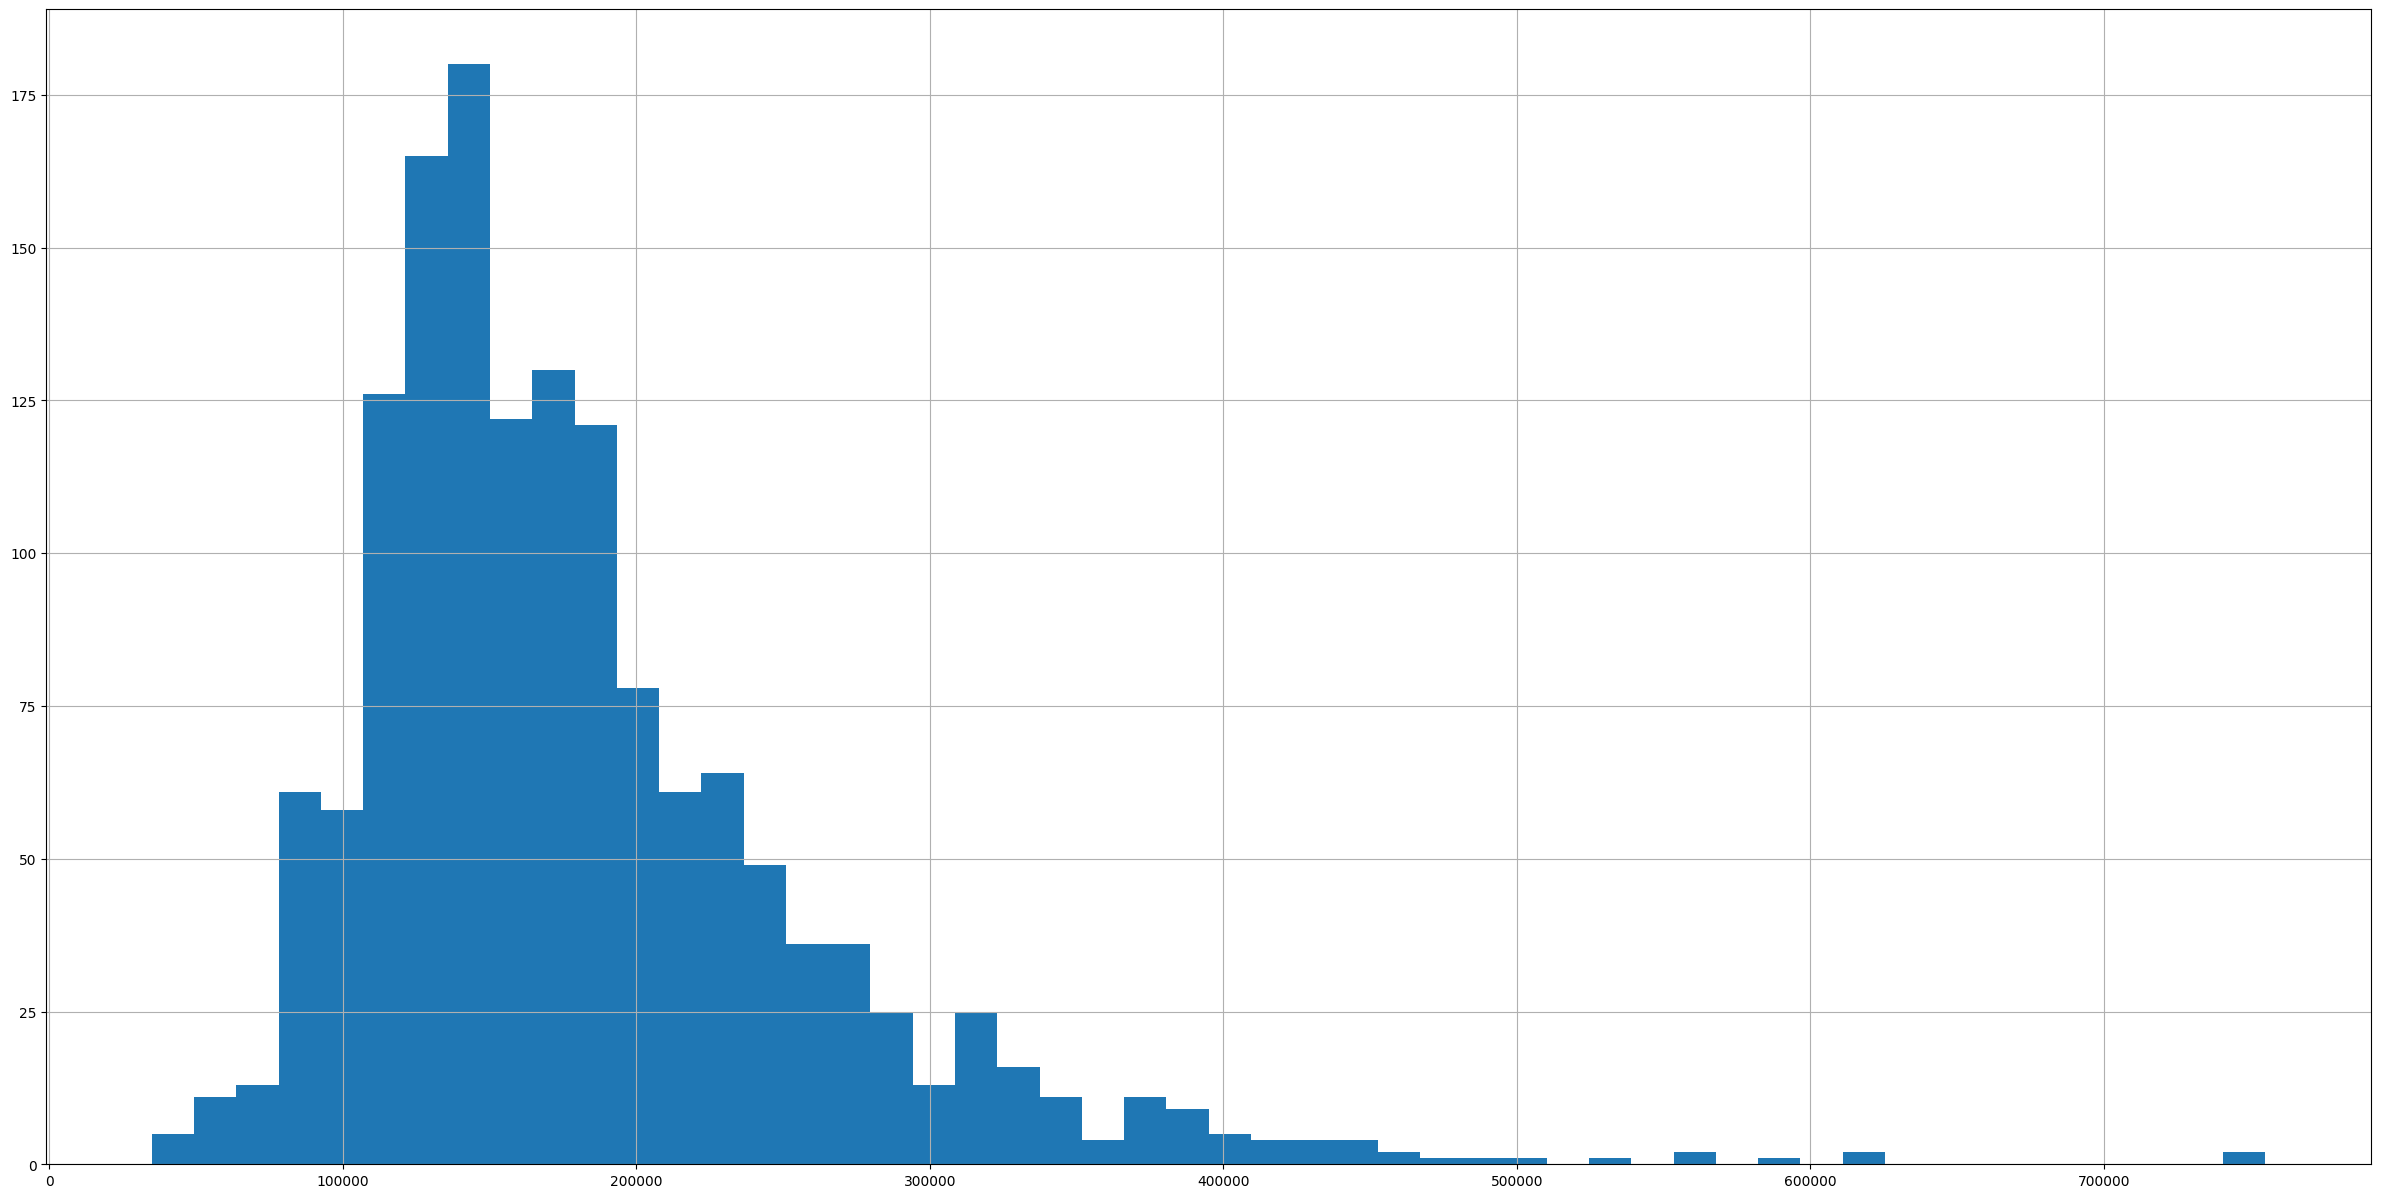

In [3]:
train_data['SalePrice'].hist(bins = 50, figsize = (30,15))
plt.show()

In [4]:
corr_matrix = train_data.corr(numeric_only = True)
corr_matrix['SalePrice'].sort_values(ascending = False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

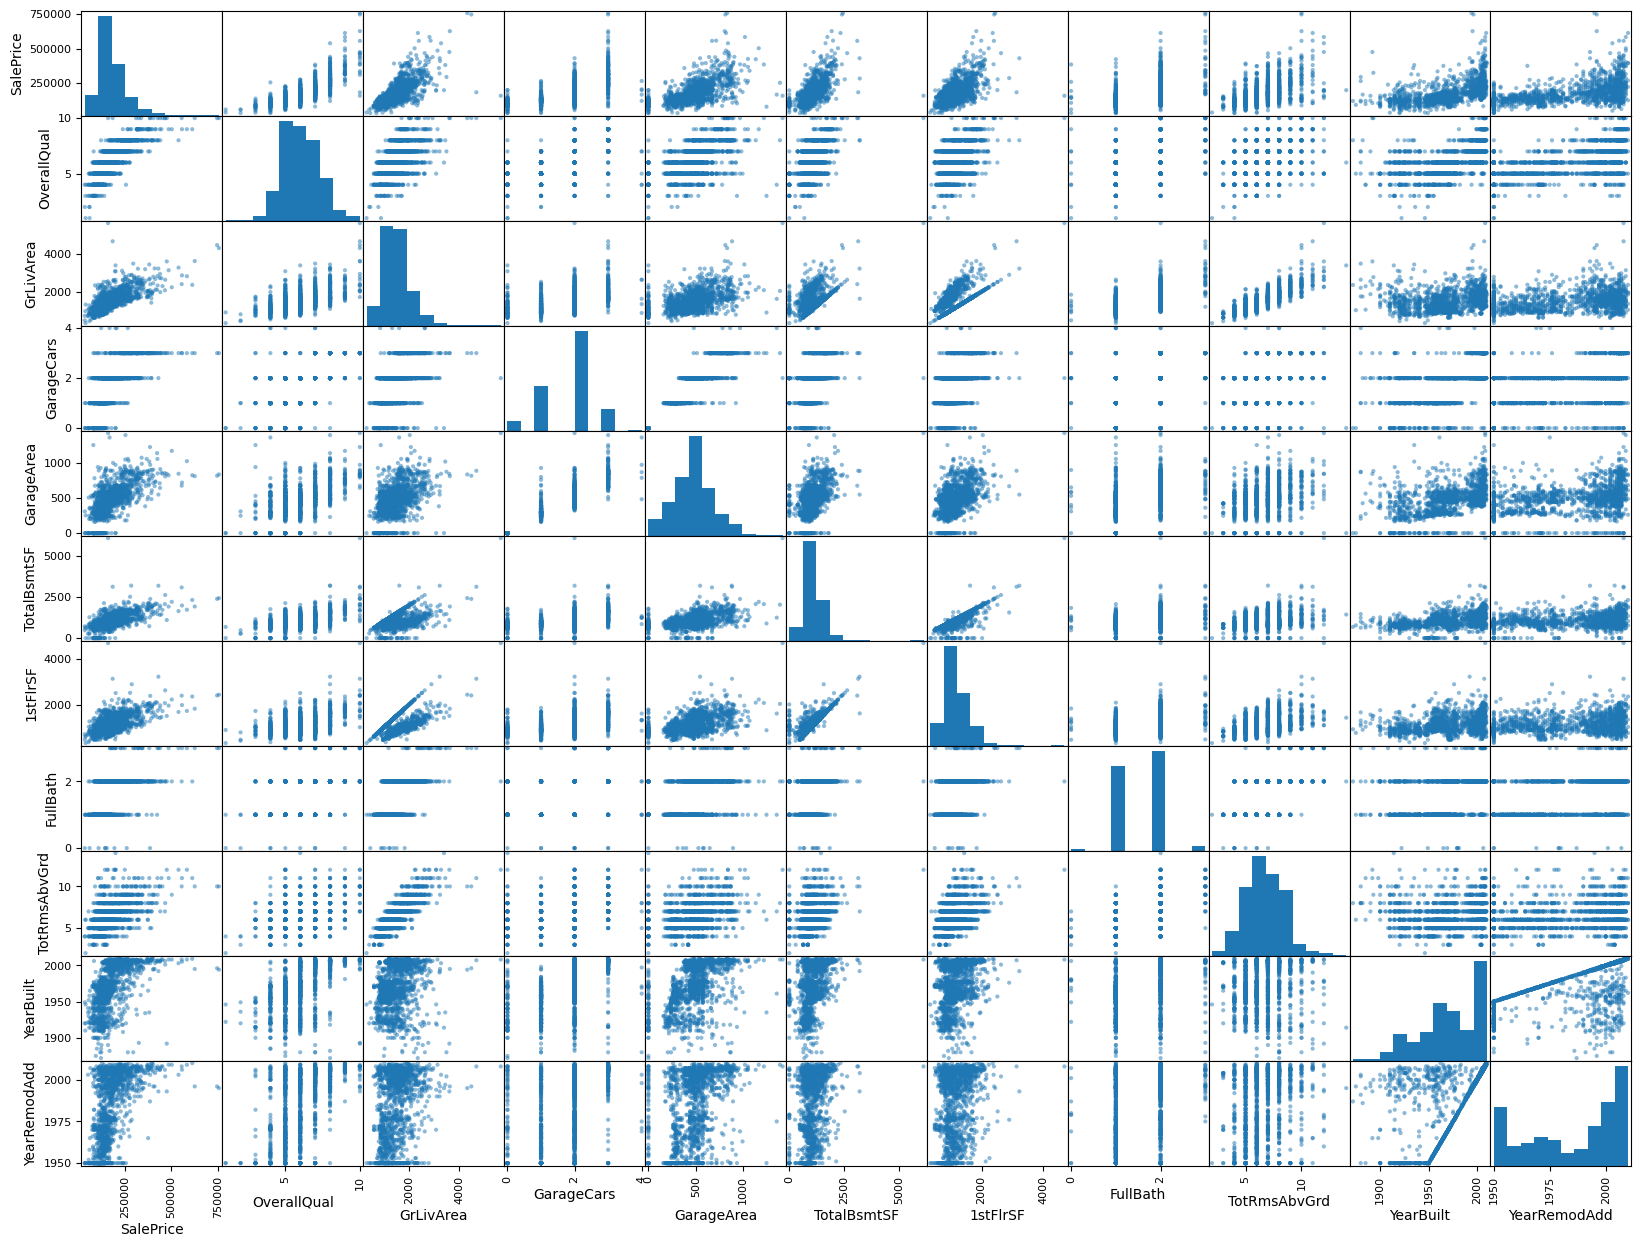

In [5]:
from pandas.plotting import scatter_matrix
highly_correlated_columns = corr_matrix['SalePrice'].sort_values(ascending = False)[0:11].axes[0].tolist()
# Pick the first 10 columns to plot against SalePrice
scatter_matrix(train_data[highly_correlated_columns], figsize = (20,15))
plt.show()

From this preliminary exploration, there a few things to note. The first is that the data is right-skewed. Therefore, in order to successfully apply a linear regression, we will need to transform the data. The natural (no pun intended) thing to do is to take the logarithm of the data, although one needs to be careful. In particular, the second point to make is that there is clearly heteroscedasticity in the relationship between sale price and some of the most strongly correlated variables. In this case, it seems that this will be the right thing to do, since it looks like the heteroscedasticity is proportional to the conditional mean. If, on the other hand, the heteroscedasticity was inversely proportional to the conditional mean, so that, for example, the variance *decreased* as the graded living area increased, then taking logarithms would exacerbate the problem. This is discussed in https://stats.stackexchange.com/questions/336315/will-log-transformation-always-mitigate-heteroskedasticity. 

Thirdly, we can see from the description that some of the scales are very different. We will therefore need to use a scaler as part of our pipeline. I will use the standard scaler since the outliers would mean that all of the other values will get squished into some really small window if we were to use a min-max scaling. 

In [6]:
pd.DataFrame(train_data.isnull().sum().sort_values(ascending = False), columns = ['Total'])

,Total
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
...,...
Heating,0
HeatingQC,0
MSZoning,0
1stFlrSF,0


Although there are a lot of missing values in some of the data, the competition info tells us that this reflects the non-existence of a feature, which is useful. For example, although most houses have no entry in PoolQC, this reflects that most houses don't have a pool. Similarly for the other features with very high percentages of missing values. Knowing this, we can effectively use this data.

In [7]:
for column in train_data.columns:
    if len(train_data[column].value_counts()) <= 5:
        print(train_data[column].value_counts())

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
Street
Pave    1454
Grvl       6
Name: count, dtype: int64
Alley
Grvl    50
Pave    41
Name: count, dtype: int64
LotShape
Reg    925
IR1    484
IR2     41
IR3     10
Name: count, dtype: int64
LandContour
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: count, dtype: int64
Utilities
AllPub    1459
NoSeWa       1
Name: count, dtype: int64
LotConfig
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64
LandSlope
Gtl    1382
Mod      65
Sev      13
Name: count, dtype: int64
BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64
MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64
ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64
ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: 

In [8]:
for column in train_data.columns:
    if len(train_data[column].value_counts()) >=10:
        print(train_data[column].value_counts())

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64
LotFrontage
60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: count, Length: 110, dtype: int64
LotArea
7200     25
9600     24
6000     17
9000     14
8400     14
         ..
14601     1
13682     1
4058      1
17104     1
9717      1
Name: count, Length: 1073, dtype: int64
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: count, dtype: int64
OverallQua

The above shows that essentially all streets are paved, and all but one houses has AllPub utilities. I can therefore safely drop these columns.

Given that there are several features which reflect the number of bathrooms, or the square footage of the house, it seems reasonable to create new features which reflect the total number of bathrooms, or the total square footage. Let's first check that these features are highly correlated with each other.

<Axes: >

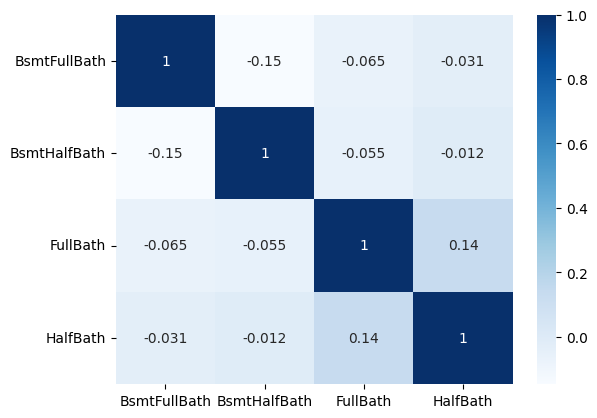

In [9]:
sns.heatmap(train_data[['BsmtFullBath','BsmtHalfBath', 'FullBath', 'HalfBath']].select_dtypes('number').corr(), cmap="Blues", annot=True)

<Axes: >

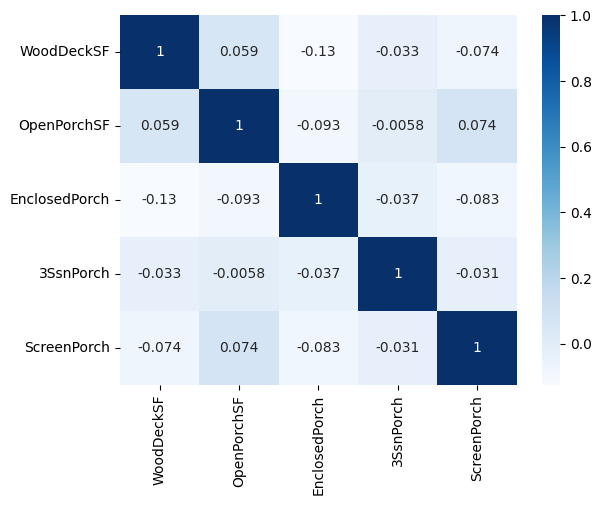

In [10]:
sns.heatmap(train_data[['WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch']].select_dtypes('number').corr(), cmap="Blues", annot=True)

Now that I've seen the results of this correlation matrix, it actually makes sense that the above are actually -- I don't think it is unreasonable that having an extra full bathroom is uncorrelated with having an extra half bathroom. Nevertheless, I think that it makes sense to group the above features together. 

<Axes: >

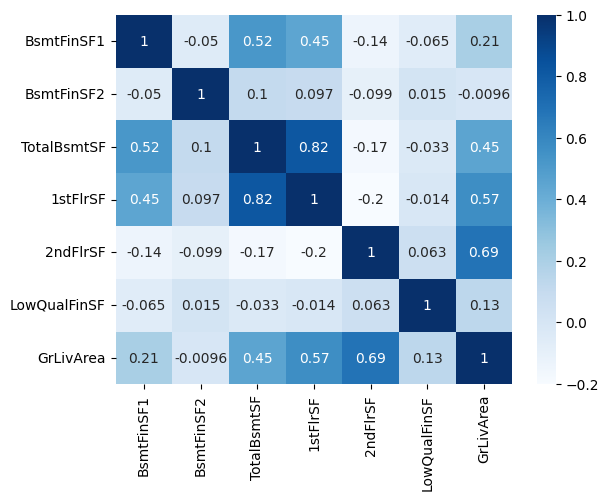

In [11]:
sns.heatmap(train_data[['BsmtFinSF1','BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea']].select_dtypes('number').corr(), cmap="Blues", annot=True)

<Axes: >

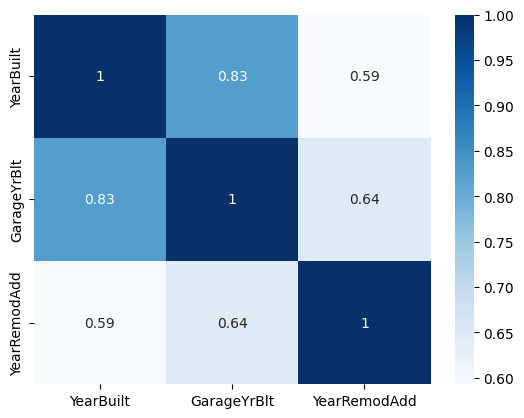

In [12]:
sns.heatmap(train_data[['YearBuilt', 'GarageYrBlt', 'YearRemodAdd']].select_dtypes('number').corr(), cmap="Blues", annot=True)

There does seem to be some correlation between these features. That makes sense -- surely GrLivArea is essentially just a sum of the other living area square footages. YearBuilt, GarageYrBlt and YearRemodAdd also seem to be highly correlated. I could combine them, but it seems like taking YearBuilt would be a good proxy.

In what follows, I want to build a pipeline which :
* Imputes missing values
* One-Hot-Encodes categorical features
* Scales anything which needs scaling

I want to do this in a pipeline so that I can just run the test data through the same pipeline. 

In [13]:
ToDrop = ['Utilities', 'Street', 'YearRemodAdd', 'GarageYrBlt']
Bathrooms = ['BsmtFullBath','BsmtHalfBath', 'FullBath', 'HalfBath']
DeckSqF = ['WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch','ScreenPorch']
TotalArea = ['BsmtFinSF1','BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF','2ndFlrSF','LowQualFinSF', 'GrLivArea', 'GarageArea','BsmtUnfSF']


train_data['Bathrooms'] = sum([train_data[column] for column in Bathrooms])
train_data['DeckSqF'] = sum([train_data[column] for column in DeckSqF]) 
train_data['TotalArea'] = sum([train_data[column] for column in TotalArea]) 
test_data['Bathrooms'] = sum([test_data[column] for column in Bathrooms])
test_data['DeckSqF'] = sum([test_data[column] for column in DeckSqF]) 
test_data['TotalArea'] = sum([test_data[column] for column in TotalArea]) 

train_data.drop([column for column in ToDrop + Bathrooms + DeckSqF + TotalArea], axis = 1, inplace = True)
test_data.drop([column for column in ToDrop + Bathrooms + DeckSqF + TotalArea], axis = 1, inplace = True)


In [14]:
y = np.log(train_data.SalePrice) #Take the natural logarithm to deal with skewdness and heteroscedacity. Could probably include this 
# in a pipeline step, but it's pretty straightforward to just take the logarithm. 
train_data.drop('SalePrice', axis = 1, inplace = True)
train_data_numerical = train_data.select_dtypes(exclude = 'object')


In [15]:

categorical_cols = [cname for cname in train_data.columns if train_data[cname].dtype == "object"]
numerical_cols = [cname for cname in train_data.columns if train_data[cname].dtype in ['int64', 'float64']]

skewed_feats = train_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew Before Transformation' :skewed_feats})
skewness = skewness[abs(skewness) >= 0.7].dropna(axis=0)
skewed_features = skewness.index
for feat in skewed_features:
    train_data[feat] = np.log1p(train_data[feat])
    test_data[feat] = np.log1p(test_data[feat])
    

numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



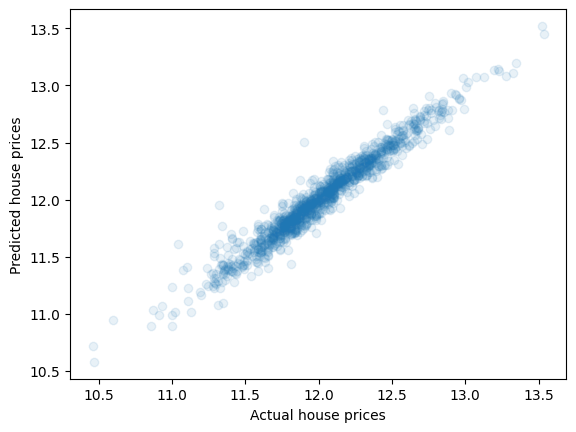

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Split the data
X_train, X_test, y_train, y_test = train_test_split(train_data, y, train_size = 0.8)

lr_model = LinearRegression()
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor), 
                              ('model', lr_model)
                             ])
my_pipeline.fit(X_train, y_train)
y_train_predict = my_pipeline.predict(X_train)
plt.scatter(y_train, y_train_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()

This looks generally in the right direction.

In [17]:
RMSE_train = mean_squared_error(y_train, y_train_predict)**0.5
print(f"RMSE of the training data is: {RMSE_train}")

RMSE of the training data is: 0.09121943643156707


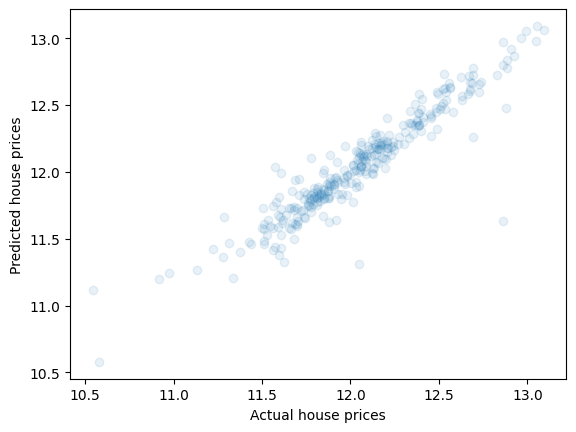

In [18]:
y_test_predict = my_pipeline.predict(X_test)
plt.scatter(y_test, y_test_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()

In [19]:
RMSE_test = mean_squared_error(y_test, y_test_predict)**0.5
print(f"RMSE of the training data is: {RMSE_test}")

RMSE of the training data is: 0.14173227529813962


I don't think that this is too bad, but it is overfitting. This is to be expected though, since we haven't done any regularisation. Let's see how this naive model does. 

In [20]:
output = np.exp(my_pipeline.predict(test_data))
my_submission = pd.DataFrame({'Id': test_data.index, 'SalePrice': output})
my_submission.to_csv('LinReg.csv', index = False)

This scored .1499 on Kaggle, so is an improvement on the previous linear regression model. 

One of the clearest signs of overfitting is large coefficients for the regression. That this means the model has high variance essentially follows from the definition -- plugging in a nearby point might result in a very different output. In the following code, we plot the coefficients of the regression. Note that it is a little bit tricky to interpret which coefficient belongs to which variable though, since we have one hot encoded some variables. 

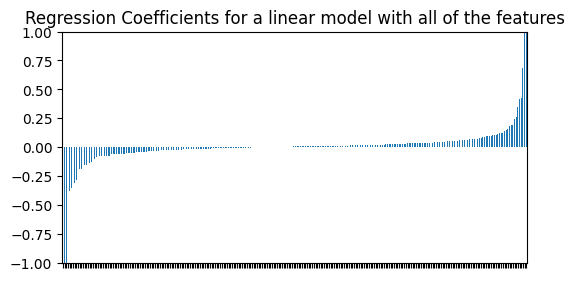

In [21]:
features = X_train.columns
coef = pd.Series(my_pipeline[1].coef_).sort_values()
plt.figure(figsize = (6,3))
plt.xticks(visible=False)
plt.ylim(-1.0,1.0)
coef.plot(kind = 'bar', title = 'Regression Coefficients for a linear model with all of the features')
plt.show()

In the following, we use Ridge (L2) regression. I experimented with lasso and elastic net, but ridge ended up working the best. 

In the following, we split the data, then split the training data again. We then do a parameter search to optimise the regularisation factor alpha. I found this to produce better results. I would think partly because outliers will not always be included in the data set.

In [22]:
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

model = Ridge()
X_train, X_test, y_train, y_test = train_test_split(train_data, y, train_size = 0.8, random_state = 42)
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                              ('model', model)
                             ])
alpha_val = 0

for i in range(100):
    X_multiple_train, X_multiple_test, y_multiple_train, y_multiple_test = train_test_split(X_train, y_train, train_size = 0.8)
    parameters = {'model__alpha' : np.logspace(0,2,10)}
    gs = GridSearchCV(my_pipeline, param_grid = parameters, scoring = 'neg_mean_squared_error', cv = 5)
    gs.fit(X_multiple_train, y_multiple_train)
    alpha_val += gs.best_params_['model__alpha']
    if i % 10 == 0:
        print(i)

alpha_val /= 100
print(alpha_val)

0
10
20
30
40
50
60
70
80
90
34.462643713577215


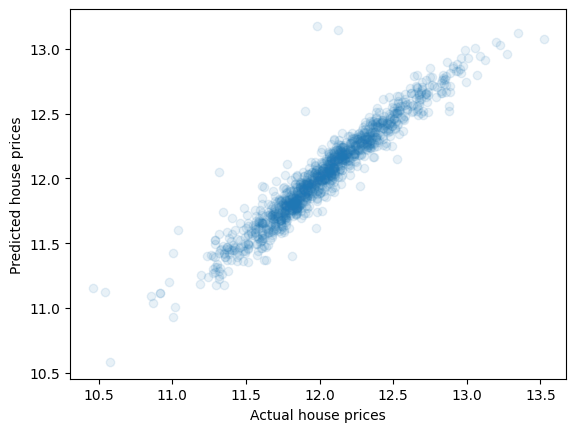

RMSE of the training data is: 0.11236141330467264


In [23]:
#Train the regularised model.
model = Ridge(alpha = alpha_val)
my_pipeline = Pipeline(steps = [('preprocessor', preprocessor), 
                              ('model', model)
                             ])
my_pipeline.fit(X_train, y_train)
y_train_predict = my_pipeline.predict(X_train)
plt.scatter(y_train, y_train_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()
RMSE_train = mean_squared_error(y_train, y_train_predict)**0.5
print(f"RMSE of the training data is: {RMSE_train}")

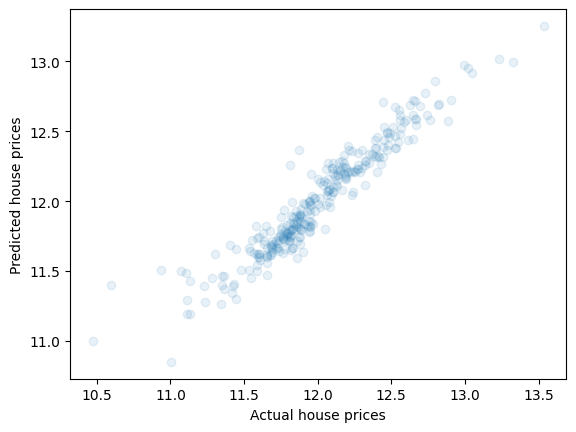

RMSE of the test data is: 0.1332378017437568


In [24]:
y_test_predict = my_pipeline.predict(X_test)
plt.scatter(y_test, y_test_predict, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()
RMSE_test = mean_squared_error(y_test, y_test_predict)**0.5

print(f"RMSE of the test data is: {RMSE_test}")

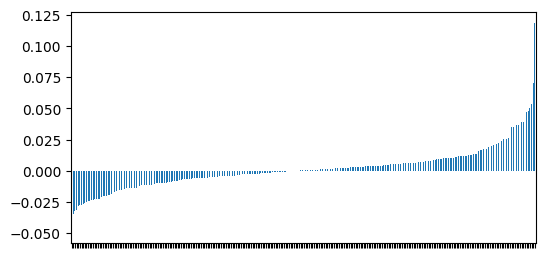

In [25]:
coef = pd.Series(my_pipeline[1].coef_).sort_values()
plt.figure(figsize=(6, 3))
coef.plot(kind='bar')
plt.xticks(visible=False)
plt.show()

This has clearly regularised the model -- the coefficients are now much smaller, and there is less of a difference between the test and training scores. Let's see we how score on the competition. 

In [26]:
output = np.exp(my_pipeline.predict(test_data))
my_submission = pd.DataFrame({'Id': test_data.index, 'SalePrice': output})
my_submission.to_csv('LinRegWithElastic.csv', index = False)

Yes, this received a Kaggle score of 13.9, which is a good improvement. Let's try training 1000 models cheaply and seeing what they average out to.

0
100
200
300
400
500
600
700
800
900


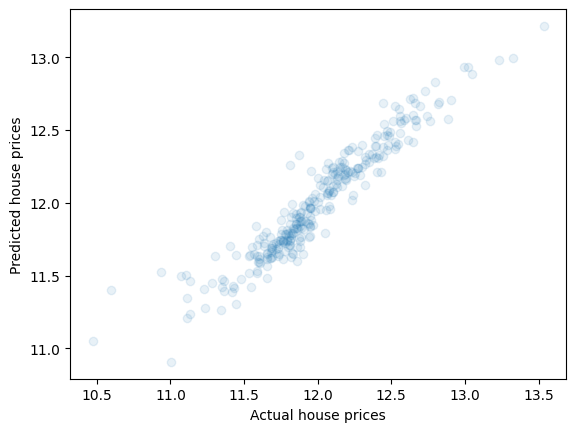

0.13643205482410528


In [27]:
output = np.zeros((y_test.size))
for i in range(1000):
    X_multiple_train, _, y_multiple_train,_ = train_test_split(X_train, y_train, train_size = 0.4)
    model = Ridge(alpha = alpha_val)
    my_pipeline = Pipeline(steps = [('preprocessor', preprocessor), 
                              ('model', model)
                             ])
    my_pipeline.fit(X_multiple_train, y_multiple_train)
    model_output = my_pipeline.predict(X_test)
    output = np.add(output, model_output)
    if i % 100 == 0:
        print(i)

y_test_pred = output / 1000
plt.scatter(y_test, y_test_pred, alpha = 0.1)
plt.xlabel("Actual house prices")
plt.ylabel("Predicted house prices")
plt.show()
RMSE_train = mean_squared_error(y_test, y_test_pred)**0.5
print(RMSE_train)

This doesn't seem to be an improvement on the test accuracy in comparison to only training one model; however, running the code multiple times with different seeds yields quite different results, with this being one of the poorer. This tells me that I should probably look more into creating a better train-test-split.

In [28]:
# train on the whole dataset, make many predictions, then average
output = np.zeros((len(test_data)))
for i in range(1000):
    X_multiple_train, _, y_multiple_train,_ = train_test_split(train_data, y, train_size = 0.4)
    model = Ridge(alpha = alpha_val)
    my_pipeline = Pipeline(steps = [('preprocessor', preprocessor), 
                              ('model', model)
                             ])
    my_pipeline.fit(X_multiple_train, y_multiple_train)
    model_output = my_pipeline.predict(test_data)
    output = np.add(output, model_output)
    if i % 100 == 0:
        print(i)

y_pred = output / 1000

0
100
200
300
400
500
600
700
800
900


In [29]:
output = np.exp(y_pred)
my_submission = pd.DataFrame({'Id': test_data.index, 'SalePrice': output})
my_submission.to_csv('LinRegWithRidge.csv', index = False)
my_submission.head()

,Id,SalePrice
0,1461,115892.031936
1,1462,153228.473783
2,1463,176456.850211
3,1464,199311.592640
4,1465,184984.577419


This got a score of 0.12952 on Kaggle, which I think is pretty good!

Overall, I think that this model is pretty good, and I believe that we have effectively improved upon our previous code through feature selection and regularisation. There are certainly other things that we could do. 
* Better feature selection. I have done this intuitively, and it is possible that grouping features differently would have worked better, for example. 
* There seem to be some significant outliers in the data, although dealing with this properly might be tricky. Some data points are clearly outliers (for example in the plot of GrLivArea vs SalePrice), but it can be dangerous to start pruning the data too much. I think that I have effectly delt with this by training multiple models and averaging, so that these outliers lose their signficance, but I am sure the model could be improved by more effectively dealing with outliers. 
* Rather than telling train_test_split to split my data, I could write a custom function to randomly split the data so that the validation data is representative of the overall data. At present, it is possible (although unlikely), that the houses in the 80th sale price percentile and above are selected as the validation data, which would mean that my model is trained without having seen any expensive houses. It is also not realistic that all unseen data corresponds to expensive houses. Whilst this is an extreme example, writing a custom function would guarantee that my train and test data are reasonably representative. The fact that running the model multiple times with different seeds can produce very varied results suggests that this would be a good improvement. 

